In [2]:
import pandas as pd
import numpy as np
import arcpy
import os
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pydotplus
from IPython.display import Image
from matplotlib.ticker import FuncFormatter
%matplotlib inline

PATH = 'C:\\Users\\Charles\\Documents\\ArcGIS\\SF_election_2016'

In [3]:
source_files = [x for x in os.listdir(PATH + '\\derived_data') if x.endswith('.txt') and x != 'SF_2010_pop_block.txt']
exclude = [
    '110 - U.S. Representative, District 12.txt',
    '115 - U.S. Representative, District 13.txt',
    '120 - U.S. Representative, District 14.txt',
    '140 - Board of Supervisors, District 1.txt',
    '145 - Board of Supervisors, District 3.txt',
    '155 - Board of Supervisors, District 7.txt',
    '160 - Board of Supervisors, District 9.txt',
    '165 - Board of Supervisors, District 11.txt',
    '185 - BART Director, District 7.txt',
    '190 - BART Director, District 9.txt',
]
join_df = None
for f in source_files[:-1]:
    if f in exclude:
        continue
    df = pd.read_csv(PATH + '\\derived_data\\' + f)
    agg_dict = {x: 'sum' for x in df.columns[7:]}
    agg_dict['ballots_cast'] = 'sum'
    df = df.rename(columns={'precinct_id': 'precinctid'})
    df = df.groupby('precinctid').agg(agg_dict).reset_index()
    df = df.drop(['under_vote', 'over_vote'], axis='columns')
    df[[x for x in df.columns if x not in ('precinctid', 'ballots_cast')]] = df[[x for x in df.columns if x not in ('precinctid', 'ballots_cast')]].div(df['ballots_cast'], axis=0)
    df = df.rename(columns={x: x + '_' + f[6:-4].lower().replace(' ', '_') for x in df.columns[1:]})
    if join_df is None:
        join_df = df
    else:
        join_df = join_df.merge(df, how='left', left_on='precinctid', right_on='precinctid', suffixes=['_main', '_' + f[6:-4].lower().replace(' ', '_')])

In [4]:
feature_df = join_df.drop('precinctid', axis='columns').copy()

# Clean the feature data
feature_df = feature_df.drop([x for x in feature_df.columns if 'u.s._representative' in x or 'state_assembly' in x], axis='columns')
feature_df = feature_df[~pd.isnull(feature_df['yes_local_measure_u'])]
feature_df = feature_df[~pd.isnull(feature_df['dean_preston_board_of_supervisors,_district_5'])]

In [5]:
classes = feature_df['dean_preston_board_of_supervisors,_district_5'] > feature_df['london_breed_board_of_supervisors,_district_5']
feature_df = feature_df.drop(['dean_preston_board_of_supervisors,_district_5', 'london_breed_board_of_supervisors,_district_5'], axis='columns')

In [6]:
classifier = DecisionTreeClassifier(class_weight='balanced')
classifier.fit(feature_df.values, classes)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [7]:
d = {feature_df.columns[i]: classifier.feature_importances_[i] for i in range(len(feature_df.columns))}
sorted(d.items(), key=lambda x: x[1], reverse=True)

[('jane_kim_state_senate,_district_11', 0.61018464981426634),
 ('no_school_measure_b', 0.12244897959183704),
 ('victor_hwang_superior_court_judge,_seat_7', 0.096791629839962784),
 ('alex_randolph_member,_community_college_board', 0.086265607264472688),
 ('ian_kalin_member,_board_of_education', 0.084309133489461202),
 ('no_local_measure_s', 0.0),
 ('no_local_measure_r', 0.0),
 ('no_local_measure_q', 0.0),
 ('jill_wynns_member,_board_of_education', 0.0),
 ('no_local_measure_w', 0.0),
 ('no_local_measure_u', 0.0),
 ('no_local_measure_t', 0.0),
 ('no_local_measure_x', 0.0),
 ('yes_school_measure_a', 0.0),
 ('no_local_measure_c', 0.0),
 ('no_local_measure_p', 0.0),
 ('no_local_measure_g', 0.0),
 ('ballots_cast_member,_board_of_education', 0.0),
 ('no_local_measure_e', 0.0),
 ('no_local_measure_d', 0.0),
 ('writein_jerry_white__niles_niemuth_president_and_vice_president', 0.0),
 ('no_local_measure_j', 0.0),
 ('no_local_measure_i', 0.0),
 ('no_local_measure_h', 0.0),
 ('no_local_measure_o', 0

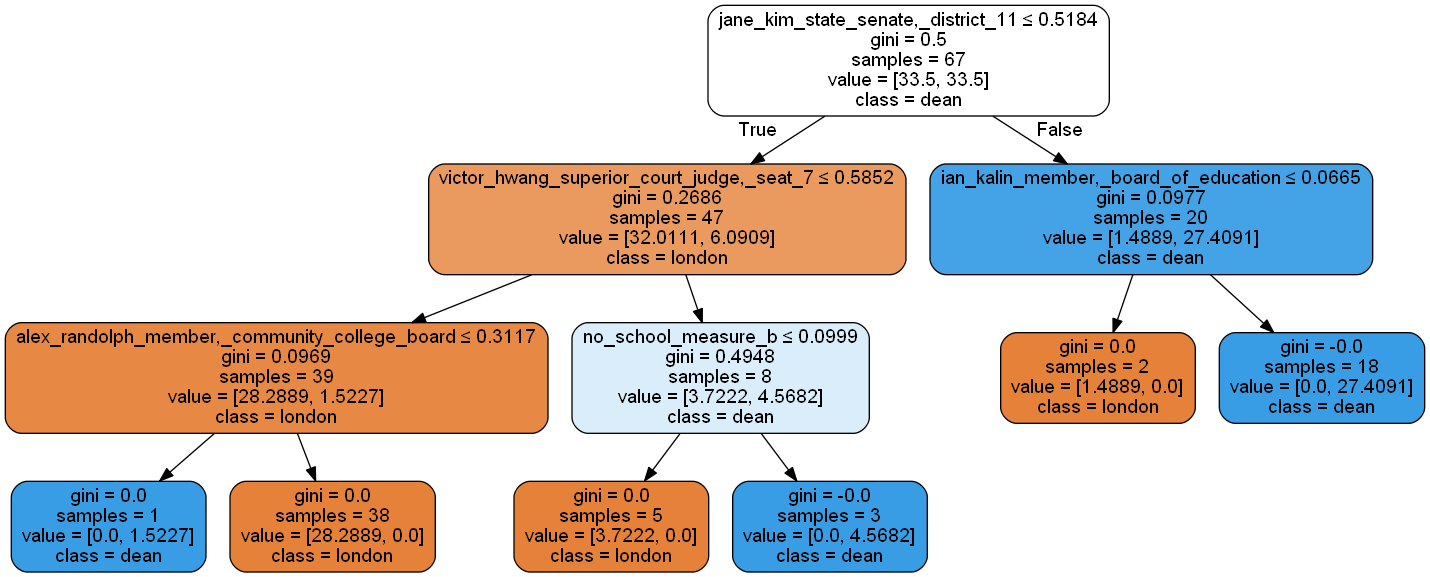

In [14]:
dot_data = tree.export_graphviz(classifier, out_file=None,
                                feature_names=feature_df.columns,
                                class_names=['london', 'dean'],
                                filled=True, rounded=True,
                                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())